# Importações

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import STL

# Conexão ao PostgreSQl

In [2]:
# user = "avnadmin"
# password = "AVNS_9fZb3BkX9qGXxKpxsrZ"
# host = "postgresql-iscac.f.aivencloud.com"
# port = "25674"
# bucket = "Seasonality"

# # URL de conexão com PostgreSQL
# engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{bucket}')

# #Nome da tabela 
# meteorology ='bicycle_counter'

# Importar dados do PostgreSQL

In [2]:
# Como a Api ainda não esta a funcionar, vou importar os dados de um csv
df = pd.read_csv('../all_bike_counts.csv', parse_dates=['detected'], dtype='int32')
df = df.set_index('detected')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22632 entries, 2021-08-01 00:00:00 to 2024-02-29 23:00:00
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   22632 non-null  int32
 1   count_2       22632 non-null  int32
 2   direction_3   22632 non-null  int32
 3   count_3       22632 non-null  int32
 4   direction_4   22632 non-null  int32
 5   count_4       22632 non-null  int32
 6   direction_5   22632 non-null  int32
 7   count_5       22632 non-null  int32
 8   direction_6   22632 non-null  int32
 9   count_6       22632 non-null  int32
 10  direction_7   22632 non-null  int32
 11  count_7       22632 non-null  int32
 12  direction_8   22632 non-null  int32
 13  count_8       22632 non-null  int32
 14  direction_9   22632 non-null  int32
 15  count_9       22632 non-null  int32
 16  direction_10  22632 non-null  int32
 17  count_10      22632 non-null  int32
 18  direction_11  22632 non-null  i

In [3]:
df_loc = pd.read_csv('../all_counter_locations.csv')
df_loc.info()
print()
print(df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB

                     direction_2  count_2  direction_3  count_3  direction_4  \
detected                                                                       
2021-08-01 00:00:00            0        0            1        1            0   
2021-08-01 01:00:00            3        3            0        2    

# Identificar se há dias com valores a zéro

In [13]:
location_ids = [8,9,12,13]  
contadores = [f"count_{loc}" for loc in location_ids]

In [5]:
df_daily = df.resample('D').sum()

In [14]:
# Identificar zeros na série
for contador in contadores:
    if contador in df_daily.columns:  
        series = df_daily[contador].copy()  
        zero_indices = series[series == 0].index  

        if not zero_indices.empty:
            print(f"Zeros encontrados na série '{contador}' nas datas: {list(zero_indices)}")


Zeros encontrados na série 'count_8' nas datas: [Timestamp('2022-08-18 00:00:00'), Timestamp('2022-08-19 00:00:00'), Timestamp('2022-08-20 00:00:00'), Timestamp('2022-08-21 00:00:00'), Timestamp('2022-08-22 00:00:00'), Timestamp('2022-08-23 00:00:00'), Timestamp('2022-08-24 00:00:00'), Timestamp('2022-08-25 00:00:00'), Timestamp('2022-08-26 00:00:00'), Timestamp('2022-08-27 00:00:00'), Timestamp('2022-08-28 00:00:00'), Timestamp('2023-01-20 00:00:00'), Timestamp('2023-10-20 00:00:00'), Timestamp('2023-10-21 00:00:00'), Timestamp('2023-10-22 00:00:00'), Timestamp('2024-01-19 00:00:00')]
Zeros encontrados na série 'count_9' nas datas: [Timestamp('2022-08-18 00:00:00'), Timestamp('2022-08-19 00:00:00'), Timestamp('2022-08-20 00:00:00'), Timestamp('2022-08-21 00:00:00'), Timestamp('2022-08-22 00:00:00'), Timestamp('2022-08-23 00:00:00'), Timestamp('2022-08-24 00:00:00'), Timestamp('2022-08-25 00:00:00'), Timestamp('2022-08-26 00:00:00'), Timestamp('2022-08-27 00:00:00'), Timestamp('2022-08

São sempre os mesmos dias que estão a zéros em todos os contadores. 

# Decomposição sazonal (STL)

### Serie original

Existem valores zero ou negativos na série count_12. Ajustando valores.
Resultados para count_12:
detected
2021-08-01    0.288529
2021-08-02   -0.105608
2021-08-03   -0.077141
2021-08-04   -0.031025
2021-08-05   -0.057081
Freq: D, Name: season, dtype: float64


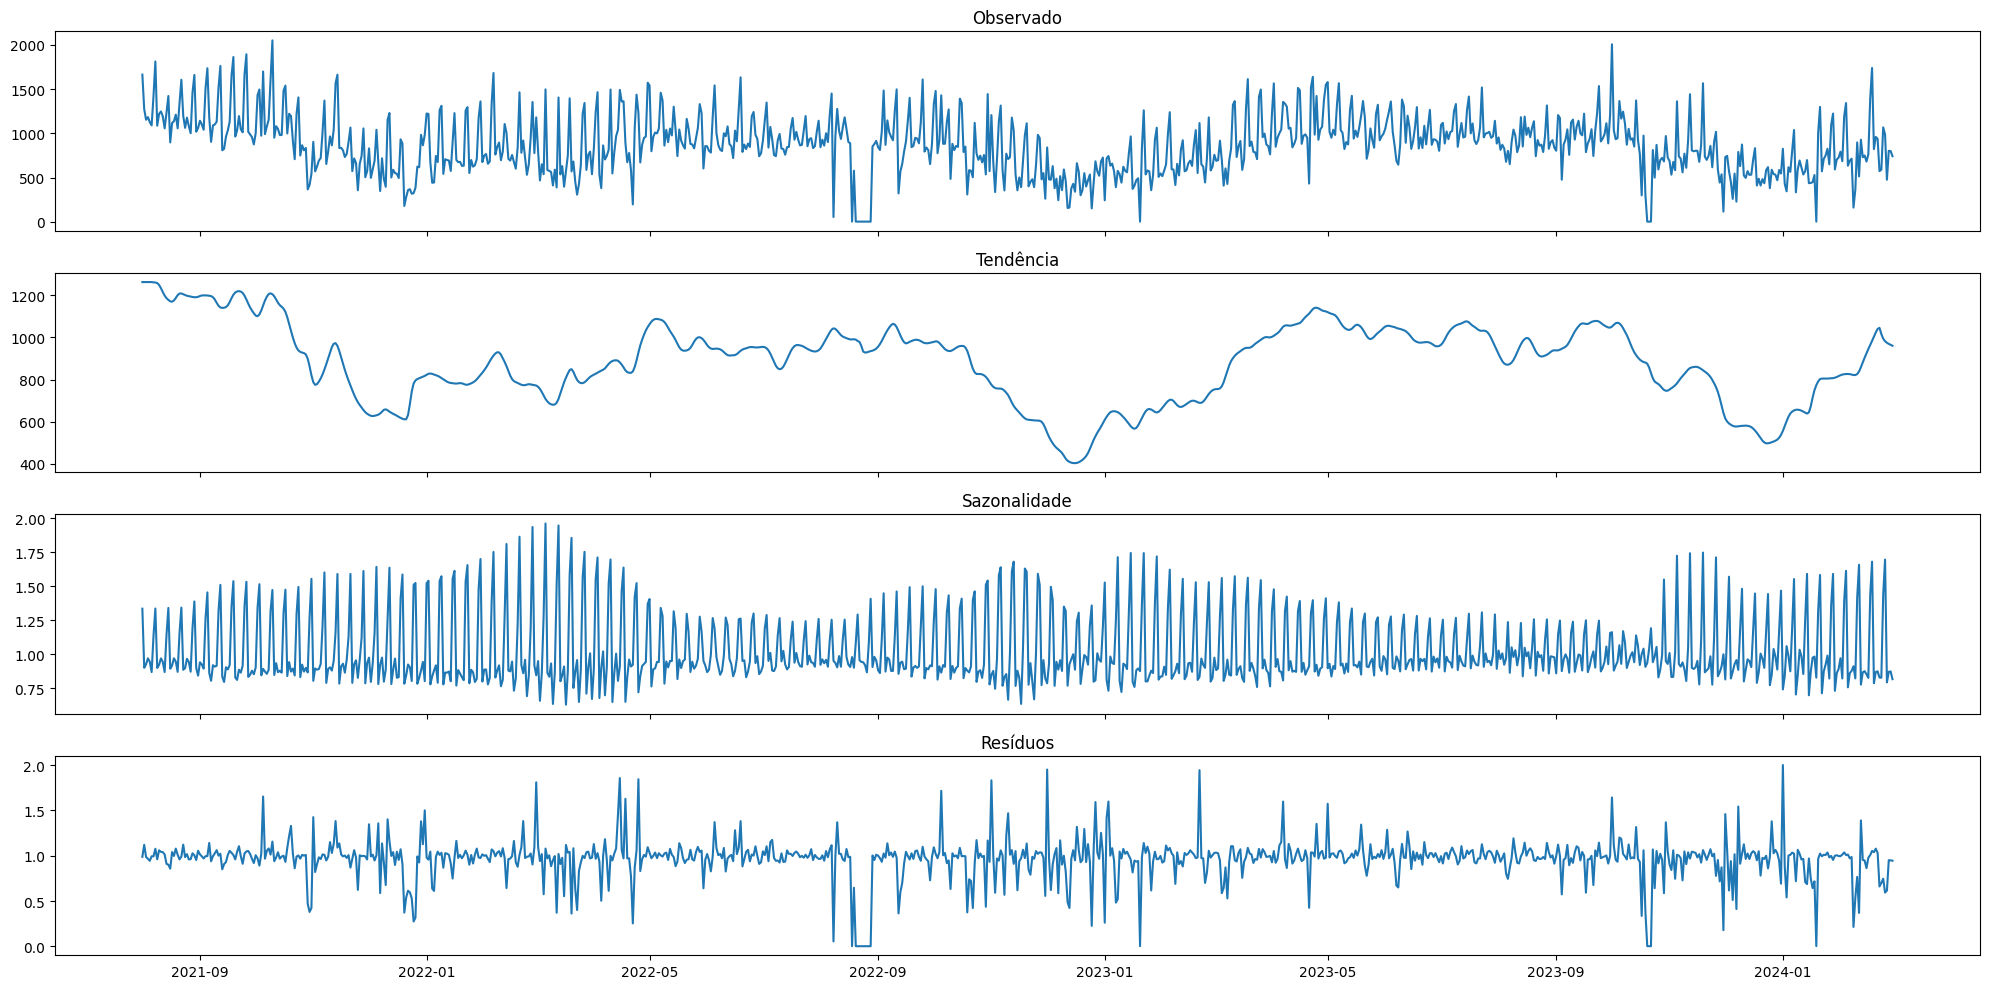

Existem valores zero ou negativos na série count_13. Ajustando valores.
Resultados para count_13:
detected
2021-08-01   -0.204233
2021-08-02    0.174999
2021-08-03    0.195482
2021-08-04    0.185099
2021-08-05    0.053794
Freq: D, Name: season, dtype: float64


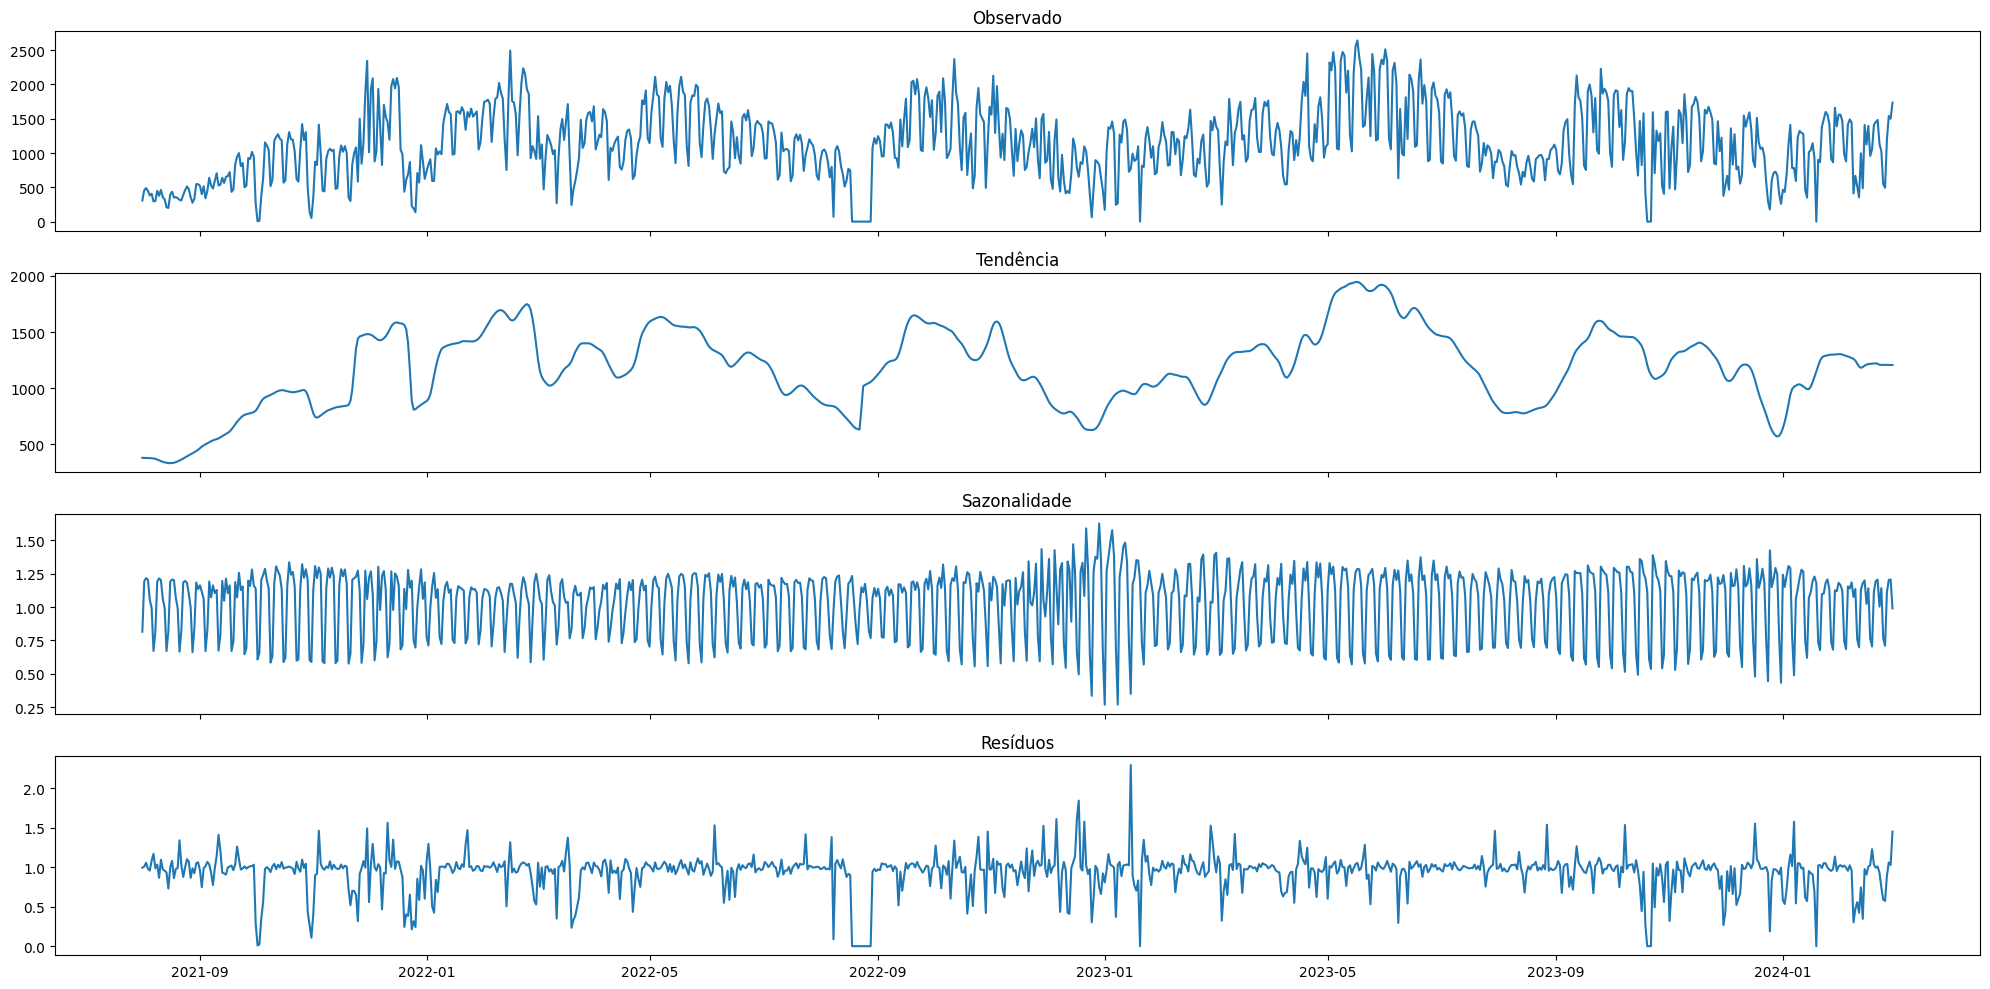

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Loop para aplicar STL aos contadores selecionados
for contador in contadores:
    if contador in df_daily.columns:  
        series = df_daily[contador].copy()

        # Verifica se há valores zero ou negativos antes de aplicar o log
        if (series <= 0).any():
            print(f"Existem valores zero ou negativos na série {contador}. Ajustando valores.")
            series = series + 1  # Ajusta todos os valores para evitar log(0) ou log(negativo)

        # Aplicar logaritmo para suavizar flutuações e focar no padrão de sazonalidade
        series_log = np.log(series)  # Usando log para suavizar variações

        # Aplica STL com sazonalidade semanal (7 dias) e parâmetros ajustados
        stl = STL(series_log, period=7, robust=True, seasonal_deg=0, trend_deg=0, low_pass_deg=0)
        res = stl.fit()

        # Exibe os primeiros valores da decomposição sazonal
        print(f"Resultados para {contador}:")
        print(res.seasonal.head())

        # Plotando as 4 componentes de decomposição: Observado, Tendência, Sazonalidade e Resíduos
        fig, ax = plt.subplots(4, 1, figsize=(20, 10), sharex=True)
        
        # Mostrar a série observada (após o log) e revertê-la para a escala original
        ax[0].plot(np.exp(res.observed))  # Revertendo para a escala original
        ax[0].set_title('Observado')
        
        # Mostrar a tendência (após o log) e revertê-la para a escala original
        ax[1].plot(np.exp(res.trend))  # Revertendo para a escala original
        ax[1].set_title('Tendência')
        
        # Mostrar a sazonalidade (após o log) e revertê-la para a escala original
        ax[2].plot(np.exp(res.seasonal))  # Revertendo para a escala original
        ax[2].set_title('Sazonalidade')
        
        # Mostrar os resíduos (após o log) e revertê-los para a escala original
        ax[3].plot(np.exp(res.resid))  # Revertendo para a escala original
        ax[3].set_title('Resíduos')
        
        plt.tight_layout()
        plt.show()


Resultados para count_12:
detected
2021-08-01    443.530915
2021-08-02   -170.935669
2021-08-03   -109.307699
2021-08-04    -58.238901
2021-08-05    -91.227717
Freq: D, Name: season, dtype: float64


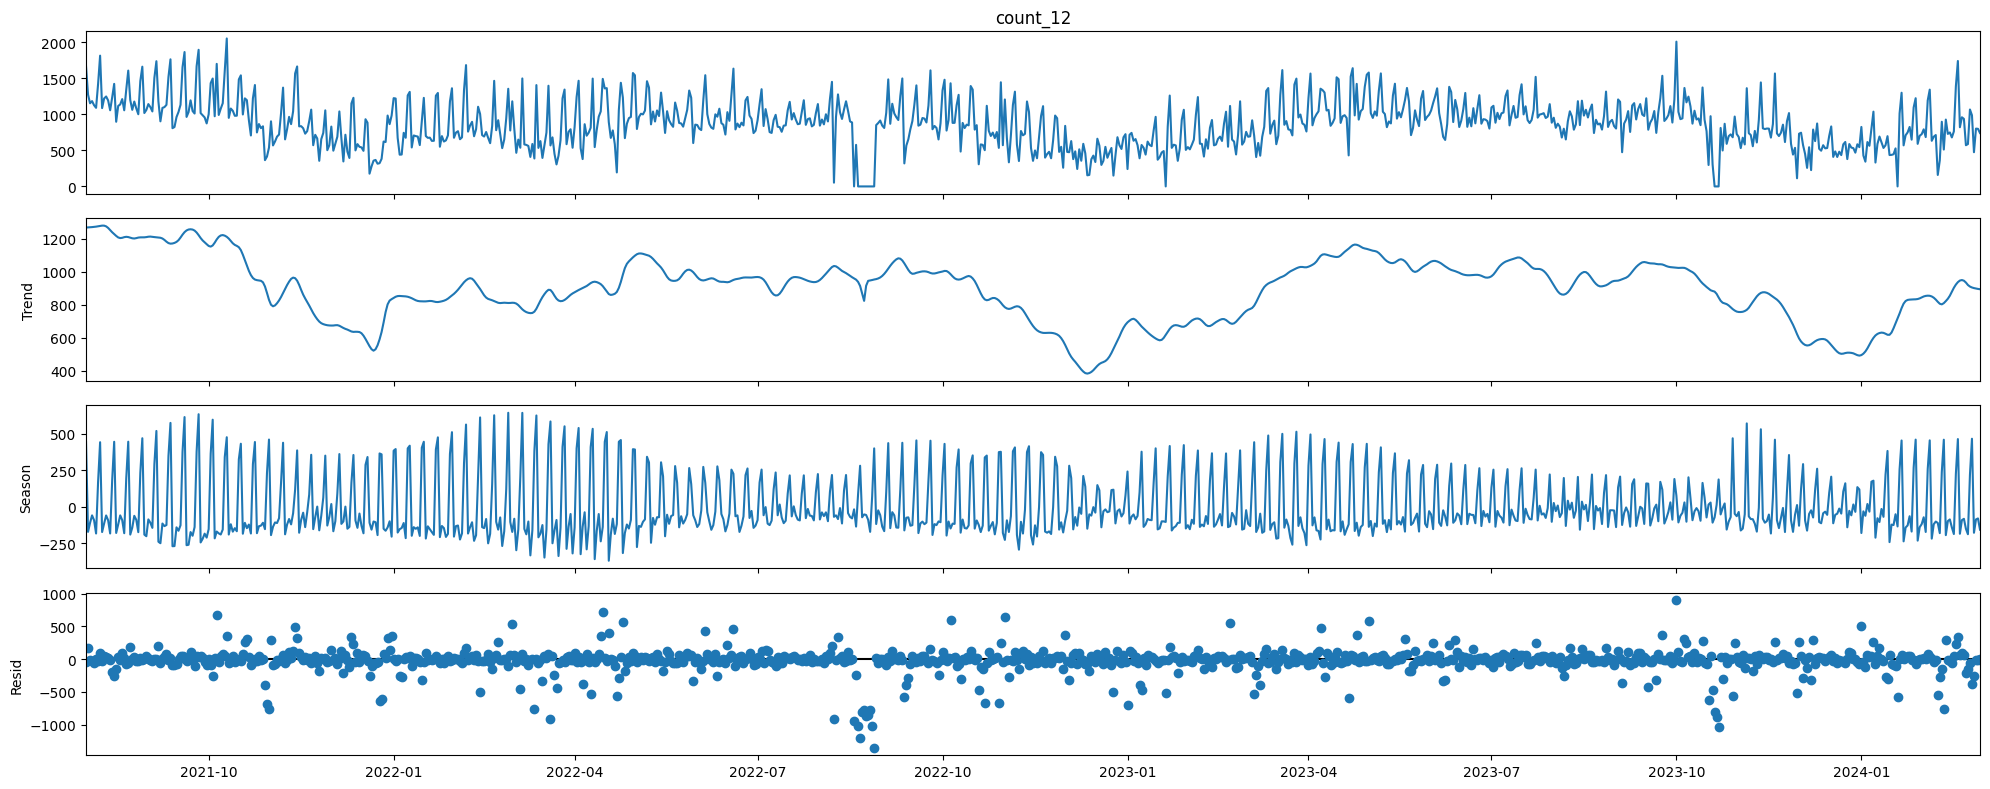

Resultados para count_13:
detected
2021-08-01   -92.356793
2021-08-02    62.067581
2021-08-03    68.935574
2021-08-04    66.208231
2021-08-05     7.942322
Freq: D, Name: season, dtype: float64


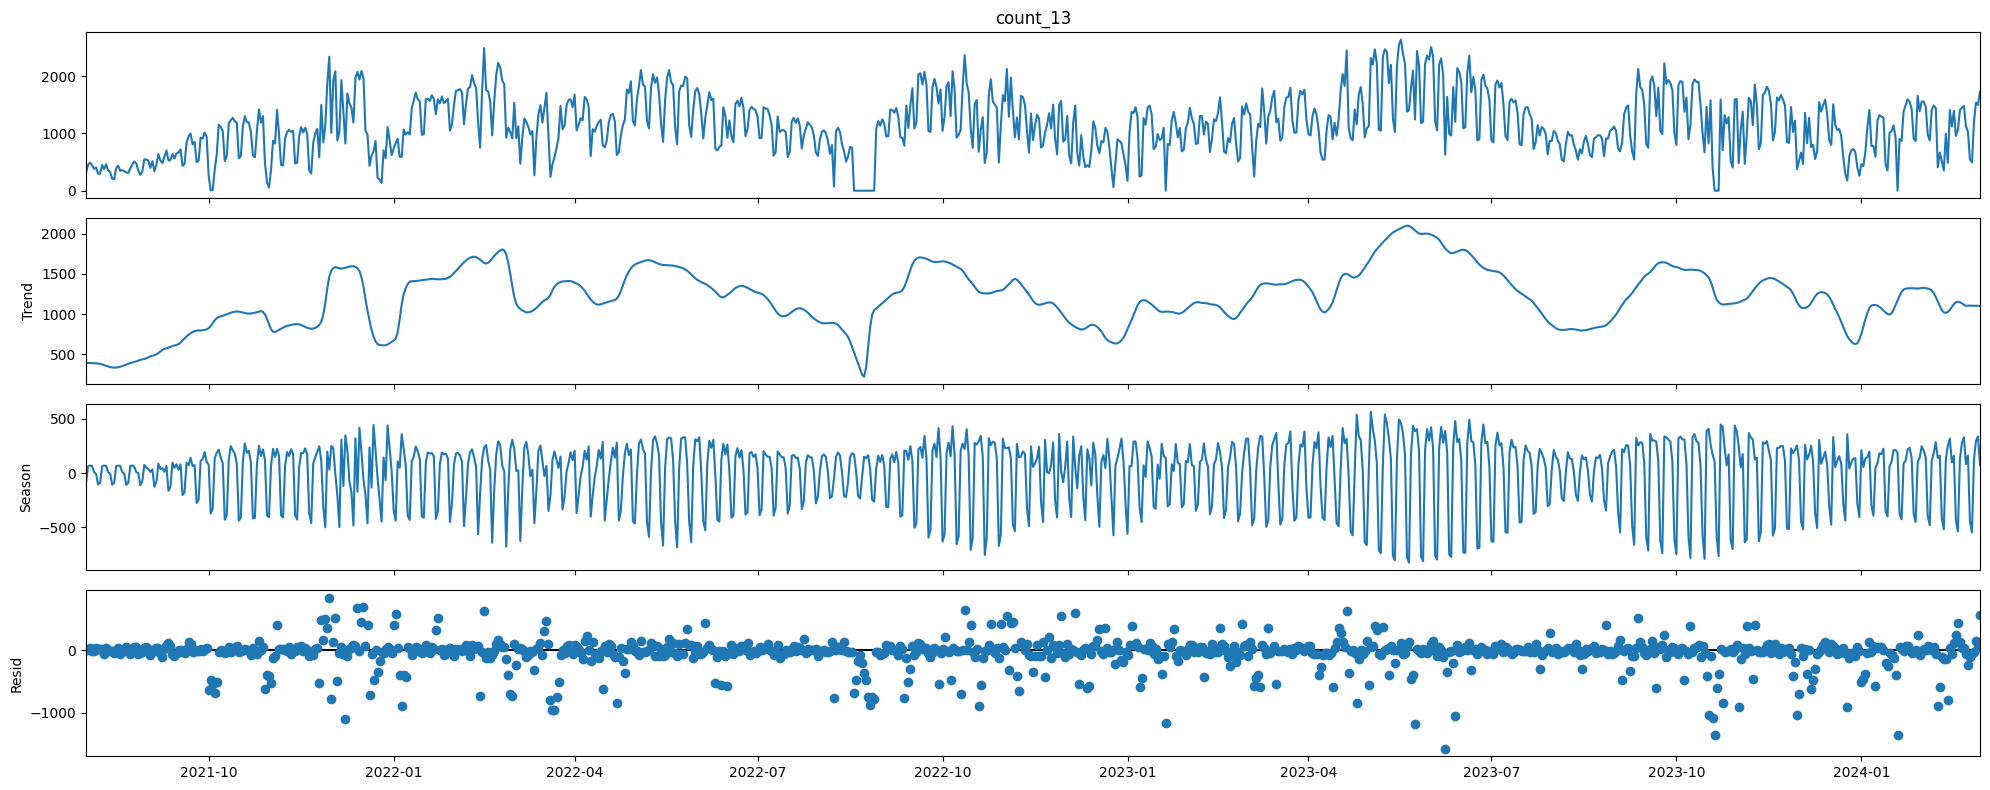

In [23]:
df_daily = df.resample('D').sum()

location_ids = [12, 13] 

# Gera os nomes das colunas com base nos location_ids escolhidos
contadores = [f"count_{loc}" for loc in location_ids]

# Loop para aplicar STL aos contadores selecionados
for contador in contadores:
    if contador in df_daily.columns:  # Verifica se a coluna existe
        series = df_daily[contador]

        # Aplica STL com sazonalidade semanal (7 dias)
        stl = STL(series, period=7, robust=True, seasonal_deg=0, trend_deg=0, low_pass_deg=0)
        res = stl.fit()

        # Exibe os primeiros valores da decomposição sazonal
        print(f"Resultados para {contador}:")
        print(res.seasonal.head())

        fig = res.plot()
        fig.set_size_inches((20, 8))
        plt.tight_layout()
        plt.show()


### Por estação do Ano

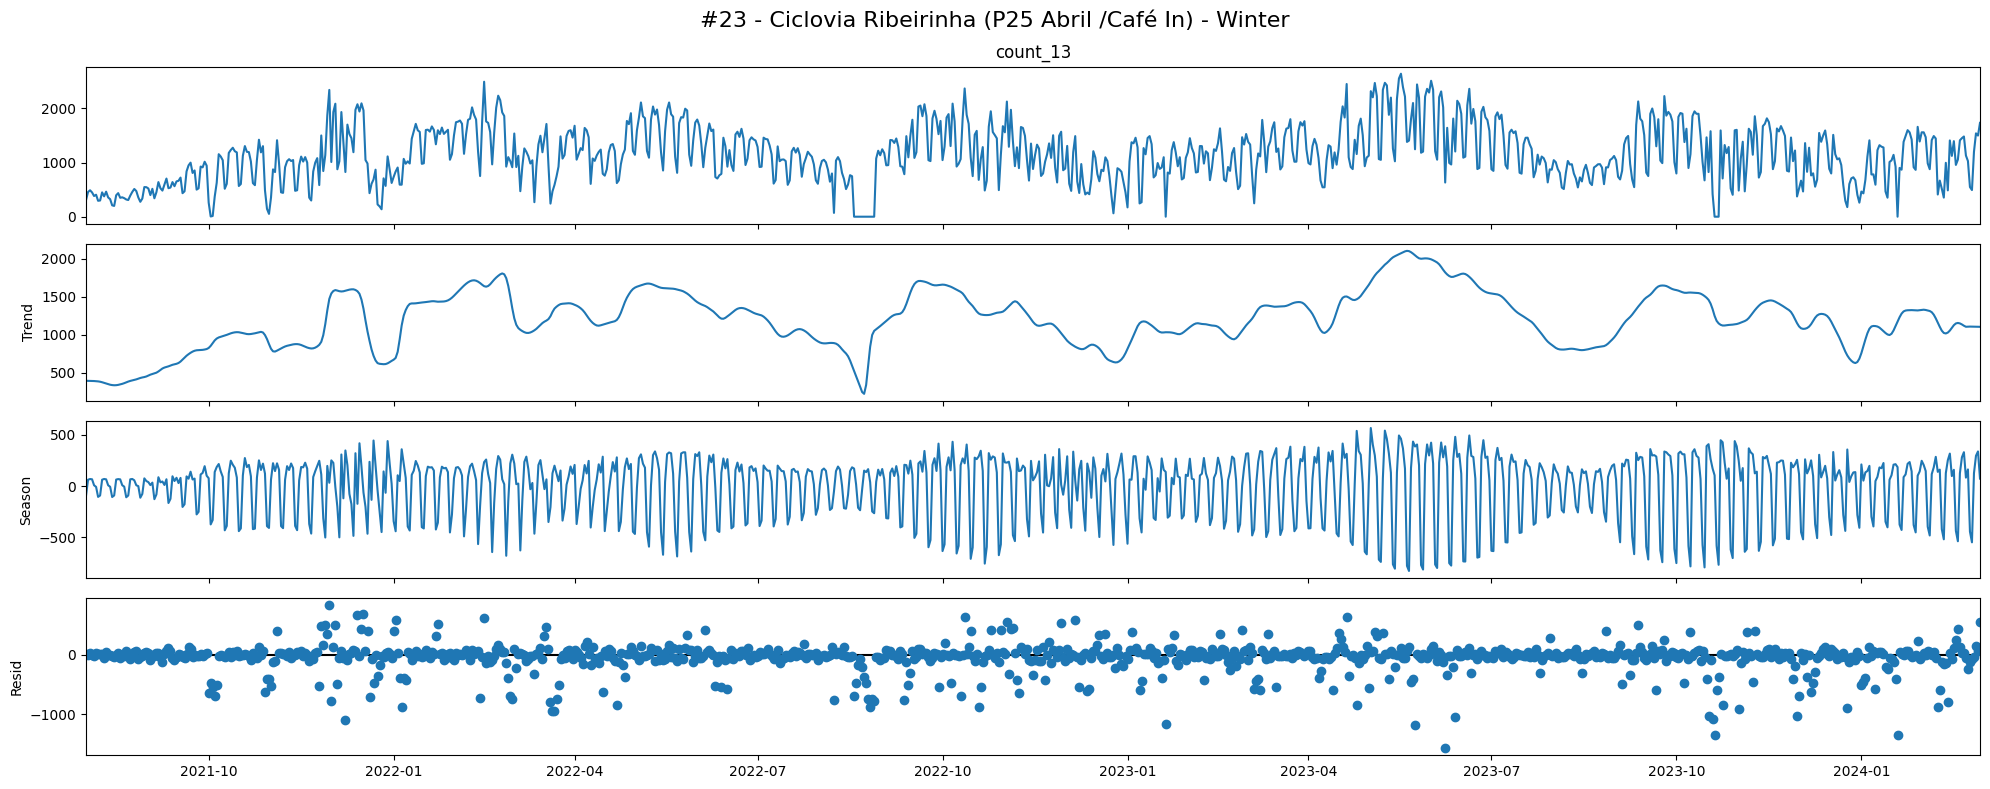

In [16]:
# Inverno

location_id = 12  

# localização
location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0]
# Filtra apenas os dados do inverno
df_winter = df[((df.index.month == 12) & (df.index.day >= 21)) | 
               (df.index.month == 1) | 
               (df.index.month == 2) | 
               ((df.index.month == 3) & (df.index.day <= 19))]

# Agrega os dados por dia
contador = f"count_{location_id}"
series_winter = df_winter.resample('D').sum()[contador]

# Remove períodos com zero ou NaN
series_winter = series_winter.loc[series_winter > 0].dropna()

# decomposição sazonal com período semanal (7 dias)
stl = STL(series, period=7, robust=True, seasonal_deg=0, trend_deg=0, low_pass_deg=0)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(20, 8)
plt.suptitle(f'{location_name} - Winter', fontsize=16)
plt.tight_layout()
plt.show()


- Sazonalidade semanal: Podemos identificar um padrões semanal ao longo dos 3 invernos. O uso varia consistentemente ao longo da semana. Parece que há um aumento no fim do inverno (pode ser ao aumento das temperaturas)
- Résiduos: Os résiduos tem de ser aléatorios e dispersos ao redor do zéro, para que haja uma boa decomposição (os résiduos não podem ter um padrão). Pontos muitos afastados indicam um evento atípico. como chuva ou um evento na cidada (fériado, concerto, etc.)

C:\Users\joana\AppData\Local\Temp\ipykernel_8892\2661442174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['weekday'] = df_winter.index.weekday


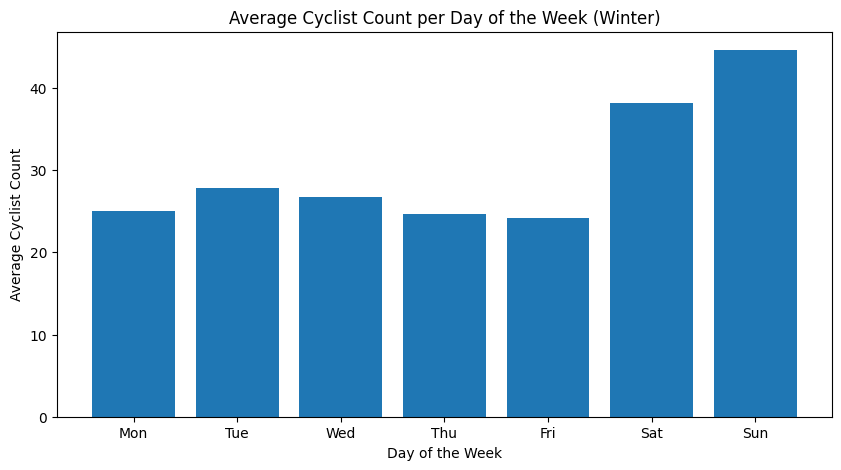

In [7]:
# Média de cicilistas para cada dia da semana ao longos dos 3 inverno 

# Adicionar uma coluna com o dia da semana (0 = segunda-feira, 6 = domingo)
df_winter['weekday'] = df_winter.index.weekday  

# Calcular a média de ciclistas por dia da semana
mean_by_weekday = df_winter.groupby('weekday')[contador].mean()

plt.figure(figsize=(10,5))
plt.bar(mean_by_weekday.index, mean_by_weekday.values, tick_label=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel("Day of the Week")
plt.ylabel("Average Cyclist Count")
plt.title("Average Cyclist Count per Day of the Week (Winter)")
plt.show()


In [8]:
# Identificar os pontos muito afastados para tentar percebe-los
# Definir um limite para outliers (ex: 3 desvios padrão dos resíduos)
limite_superior = res.resid.mean() + 3 * res.resid.std()
limite_inferior = res.resid.mean() - 3 * res.resid.std()

# Filtrar os dias que são outliers
outliers = res.resid[(res.resid > limite_superior) | (res.resid < limite_inferior)]

print(outliers)


detected
2021-12-26   -631.318748
2022-03-19    849.891908
2023-01-15    568.632678
2023-02-21    561.573221
2023-03-05   -551.764488
2023-03-19    701.932245
2024-02-11   -597.327963
Name: resid, dtype: float64


- 2021-12-26   -631.318748 --> Logo após ao Natal, cansaço das festas?
- 2022-03-19    849.891908 --> Dia do Pai. Mais passeios em família. Sendo que é um sábado, tinhamos visto que há mais utilização ao fim de semana. 
- 2023-01-15    568.632678 --> Domingo, podera ter estado bom tempo. (acima da média)
- 2023-02-21    561.573221 --> Carnaval (terça-feira)
- 2023-03-05   -551.764488 --> Domingo, mas houve uma queda da temperatura 
- 2023-03-19    701.932245 --> Dia do Pai (Domingo)
- 2024-02-11   -597.327963 --> Domingo, mas pode ter havido um fator climatico que pode ter influenciado. 

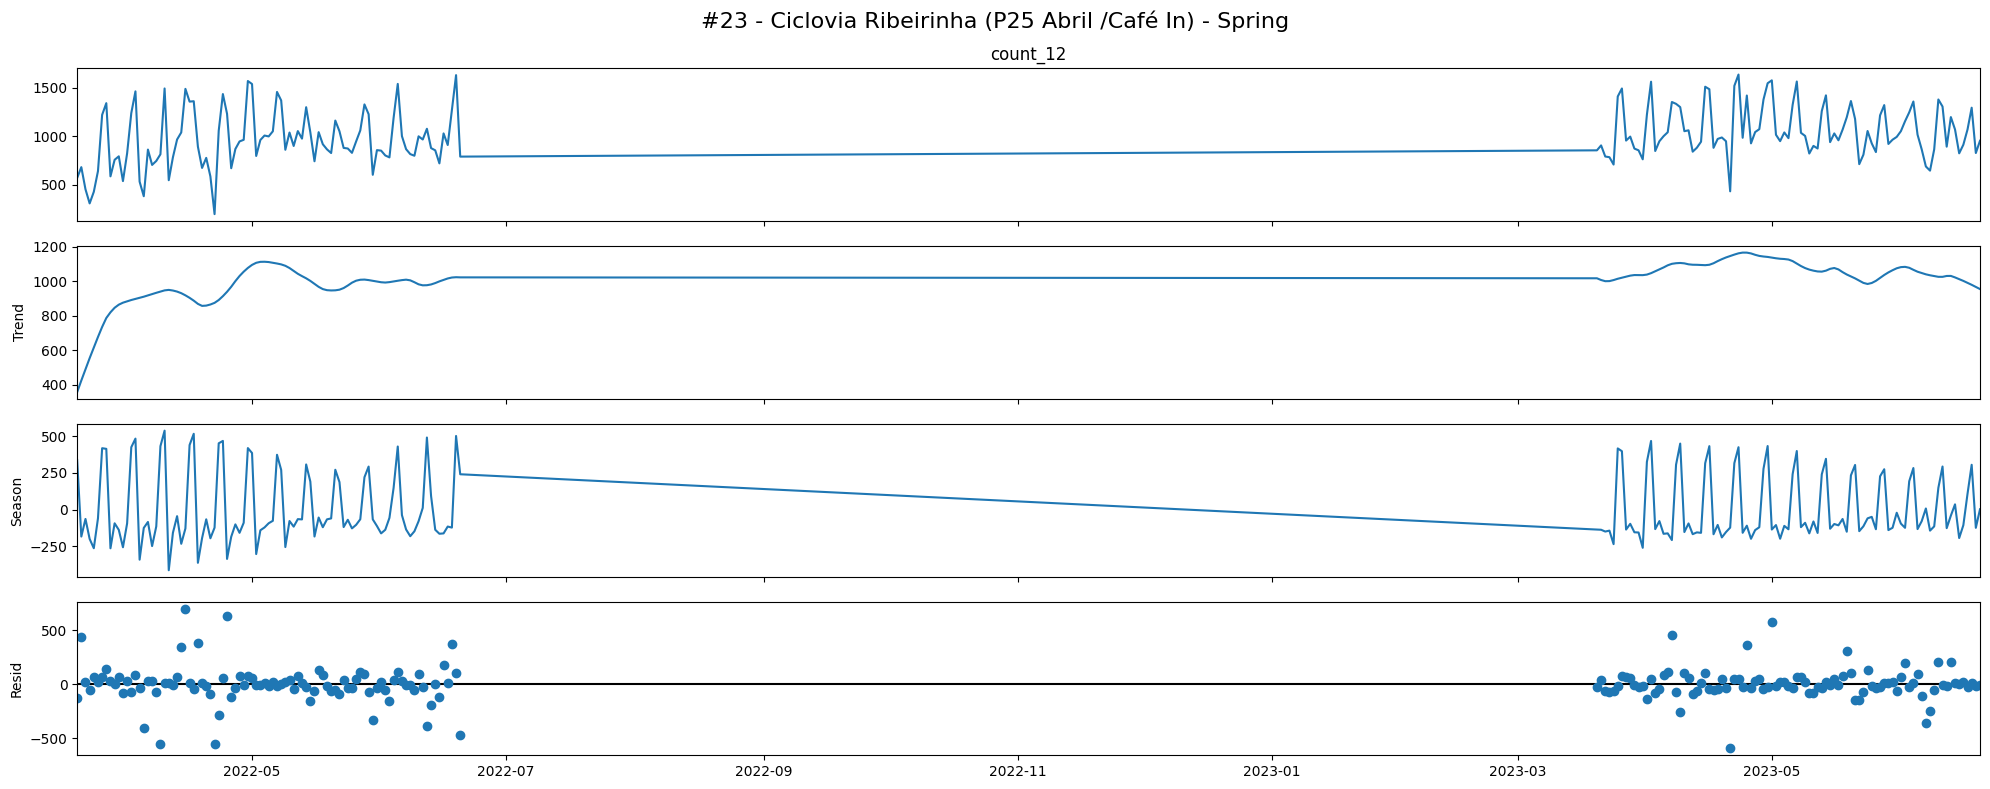

In [ ]:
# Primavera 

location_id = 12  
location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0]
df_spring = df[(df.index.month == 3) & (df.index.day >= 20) |
               (df.index.month == 4) |
               (df.index.month == 5) |
               (df.index.month == 6) & (df.index.day <= 20)]

# Agrega os dados por dia
contador = f"count_{location_id}"
series_spring = df_spring.resample('D').sum()[contador]

# Remove períodos com zero ou NaN
series_spring = series_spring.loc[series_spring > 0].dropna()

# decomposição sazonal com período semanal (7 dias)
stl = STL(series_spring, period=7, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(20, 8)
plt.suptitle(f'{location_name} - Spring', fontsize=16)
plt.tight_layout()
plt.show()



- Comparação entre a primavera e o inverno: Podemos ver que há maior utilização no inverno de 2022 que na primavera, mas que depois os outros invernos já tem menos utilização. Será que foi um inverno mais quente?
- No geral temos um aumento da utilização das bicicletas e continuas a ver um padrão semanal. Provavelmente os fins de semanas ainda são os dias com mais uso. No geral, podemos ver que há um aumento gradual ao longo da estação. Os picos negativos são menos acentuados, o que indica que há mais utilização. 

In [10]:
# Identificar os pontos muito afastados para tentar percebe-los
# Definir um limite para outliers (ex: 3 desvios padrão dos resíduos)
limite_superior = res.resid.mean() + 3 * res.resid.std()
limite_inferior = res.resid.mean() - 3 * res.resid.std()

# Filtrar os dias que são outliers
outliers = res.resid[(res.resid > limite_superior) | (res.resid < limite_inferior)]

print(outliers)

detected
2022-04-09   -556.624537
2022-04-15    701.595524
2022-04-22   -556.497495
2022-04-25    629.944133
2023-04-21   -592.331533
2023-05-01    578.035037
Name: resid, dtype: float64


- 2022-04-09   -556.624537 --> Não há um evento especifico, pode ser alteração climatica. 
- 2022-04-15    701.595524 --> Férias escolares e fériado, que pode gerar um aumento 
- 2022-04-22   -556.497495 --> Descida da temperatura
- 2022-04-25    629.944133 --> Fériado importante em Portugal que geralmente aumenta a atividade. 
- 2023-04-21   -592.331533 --> Alterações no clima?
- 2023-05-01    578.035037 --> Fériado, dia do trabalhador

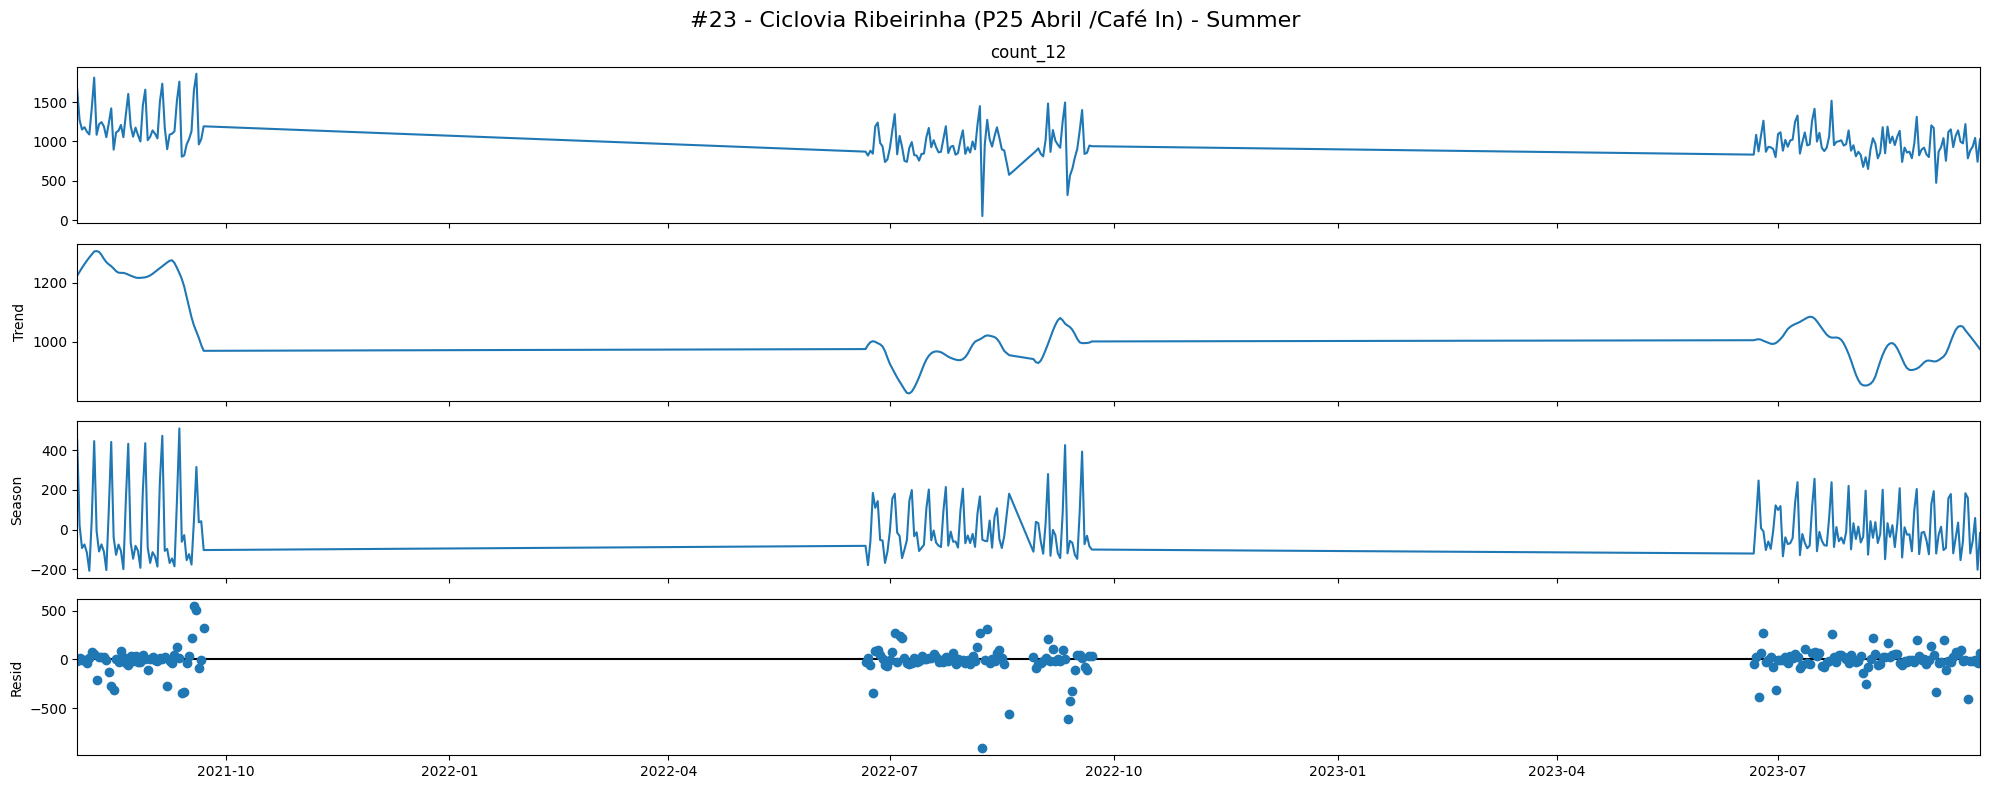

In [ ]:
# Verão

location_id = 12  
location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0]
df_summer = df[(df.index.month == 6) & (df.index.day >= 21) |
               (df.index.month == 7) |
               (df.index.month == 8) |
               (df.index.month == 9) & (df.index.day <= 22)]

# Agrega os dados por dia
contador = f"count_{location_id}"
series_summer = df_summer.resample('D').sum()[contador]

# Remove períodos com zero ou NaN 
series_summer = series_summer.loc[series_summer > 0].dropna()

# decomposição sazonal com período semanal (7 dias)
stl = STL(series_summer, period=7, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(20, 8)
plt.suptitle(f'{location_name} - Summer', fontsize=16)
plt.tight_layout()
plt.show()

- Comparação entre a primavera e o verão: No geral a utilização de bicicletas é ligeiramente maior no verão que na primavera. 
- Sazonalidade semanal: Podemos identificar um padrão semanal, com utilização maior ao fim de semana.   

In [12]:
# Identificar os pontos muito afastados para tentar percebe-los
# Definir um limite para outliers (ex: 3 desvios padrão dos resíduos, porque cerca de 99% dos dados caem dentro de 3 desvios padrões da média)
limite_superior = res.resid.mean() + 3 * res.resid.std()
limite_inferior = res.resid.mean() - 3 * res.resid.std()

# Filtrar os dias que são outliers
outliers = res.resid[(res.resid > limite_superior) | (res.resid < limite_inferior)]

print(outliers)

detected
2021-09-18    549.783361
2021-09-19    511.723923
2022-08-08   -910.784309
2022-08-19   -559.907713
2022-09-12   -616.726351
Name: resid, dtype: float64


- 2021-09-18    549.783361 + 2021-09-19    511.723923 (Sabado e domingo) --> ArcoLisboa: Feira de arte contemporânea. Evento que atrai muitas pessoas a Lisboa. 
- 2022-08-08   -910.784309 --> Segunda. Chuva?
- 2022-08-19   -559.907713 --> Depressão térmica, vento forte
- 2022-09-12   -616.726351 --> Chuva e trovoada

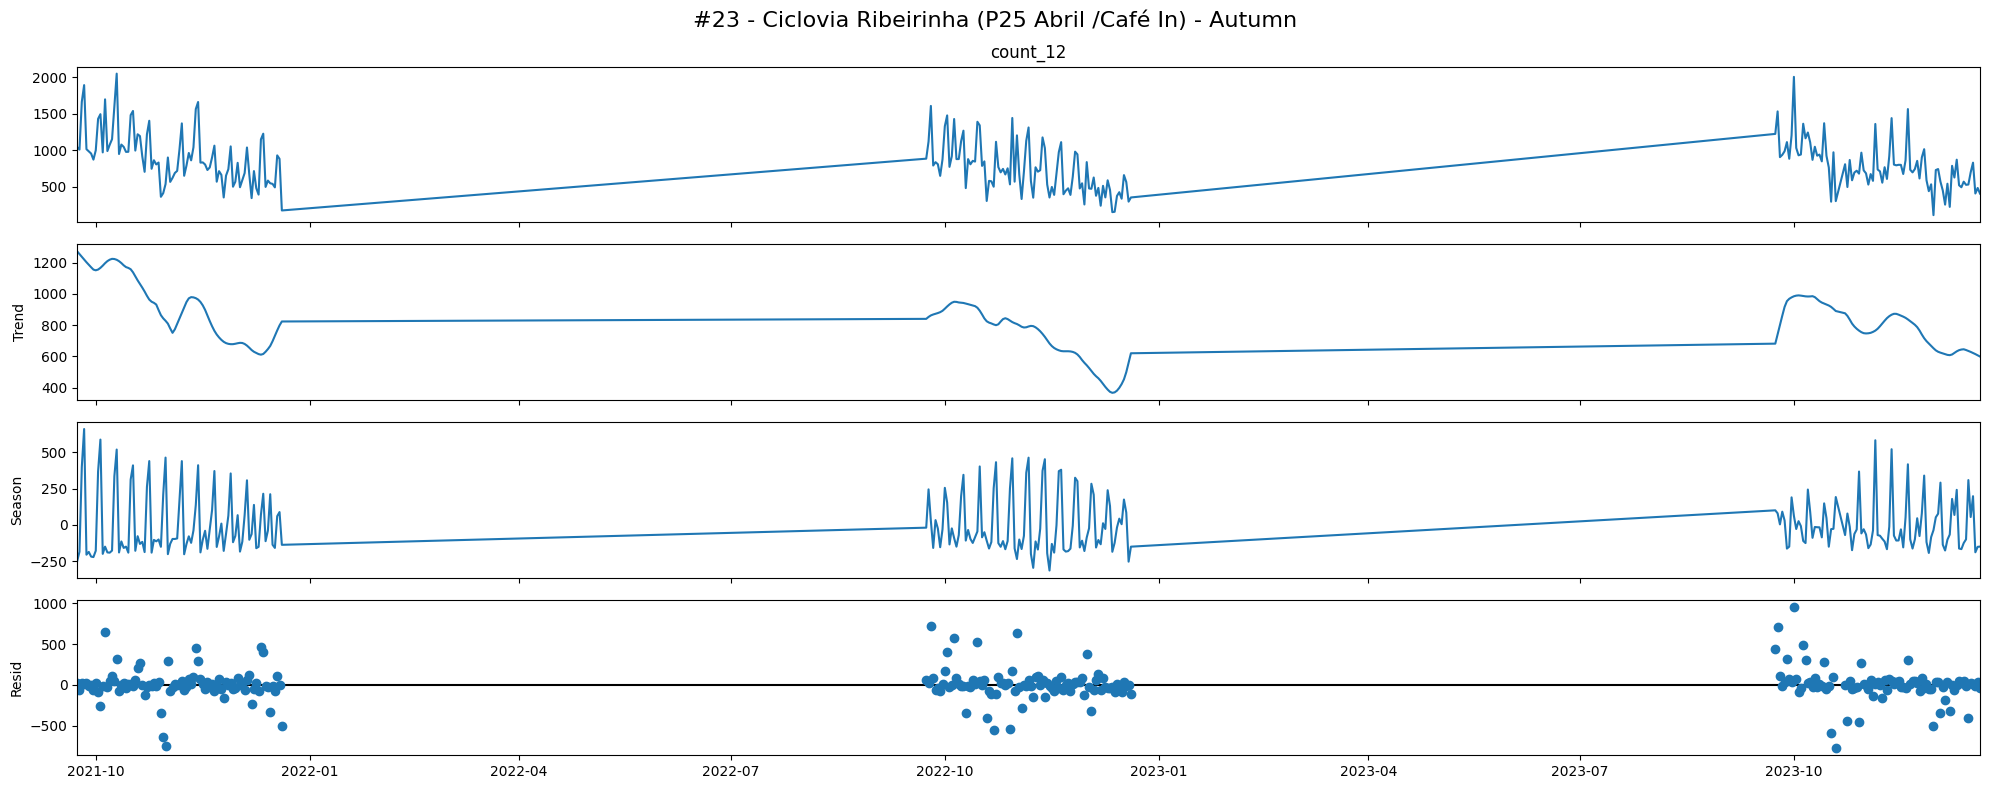

In [ ]:
# Outono

location_id = 12  
location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0]
df_autumn = df[(df.index.month == 9) & (df.index.day >= 23) |
               (df.index.month == 10) |
               (df.index.month == 11) |
               (df.index.month == 12) & (df.index.day <= 20)]

# Agrega os dados por dia
contador = f"count_{location_id}"
series_autumn = df_autumn.resample('D').sum()[contador]

# Remove períodos com zero ou NaN
series_autumn = series_autumn.loc[series_autumn > 0].dropna()

# decomposição sazonal com período semanal (7 dias)
stl = STL(series_autumn, period=7, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(20, 8)
plt.suptitle(f'{location_name} - Autumn', fontsize=16)
plt.tight_layout()
plt.show()


- Comparação entre o verão e o outuno: No geral a utilização de bicicletas é menor que no verão e provavelmente também na primavera. 
- Sazonalidade semanal: Podemos identificar um padrão semanal, com utilização maior ao fim de semana.   

In [14]:
# Identificar os pontos muito afastados para tentar percebe-los
# Definir um limite para outliers (ex: 3 desvios padrão dos resíduos, porque cerca de 99% dos dados caem dentro de 3 desvios padrões da média)
limite_superior = res.resid.mean() + 3 * res.resid.std()
limite_inferior = res.resid.mean() - 3 * res.resid.std()

# Filtrar os dias que são outliers
outliers = res.resid[(res.resid > limite_superior) | (res.resid < limite_inferior)]

print(outliers)

detected
2021-10-05    651.120365
2021-10-30   -638.344398
2021-10-31   -753.633627
2022-09-25    718.489451
2022-11-01    632.873767
2023-09-24    711.241277
2023-10-01    958.663631
2023-10-19   -777.355366
Name: resid, dtype: float64


- 2021-10-05    651.120365 --> Fériado (terça)
- 2021-10-30   -638.344398 --> sábado: Percipitação muito frote 
- 2021-10-31   -753.633627 --> Domingo: Percipitação muito frote 
- 2022-09-25    718.489451 --> Domingo
- 2022-11-01    632.873767 --> Terça, Fériado
- 2023-09-24    711.241277 --> Domingo com temperaturas de 20º
- 2023-10-01    958.663631 --> Domingo, temperaturas altas, acima da média
- 2023-10-19   -777.355366 --> Quinta, depressão BABET e ALINE, com muita chuva e rajadas de vento

### Por dias da semana 

#23 - Ciclovia Ribeirinha (P25 Abril /Café In)
Results #23 - Ciclovia Ribeirinha (P25 Abril /Café In) - week days:
detected
2021-08-02    96.864853
2021-08-03     9.769567
2021-08-04   -41.409297
2021-08-05   -17.916400
2021-08-06   -50.819376
Name: season, dtype: float64


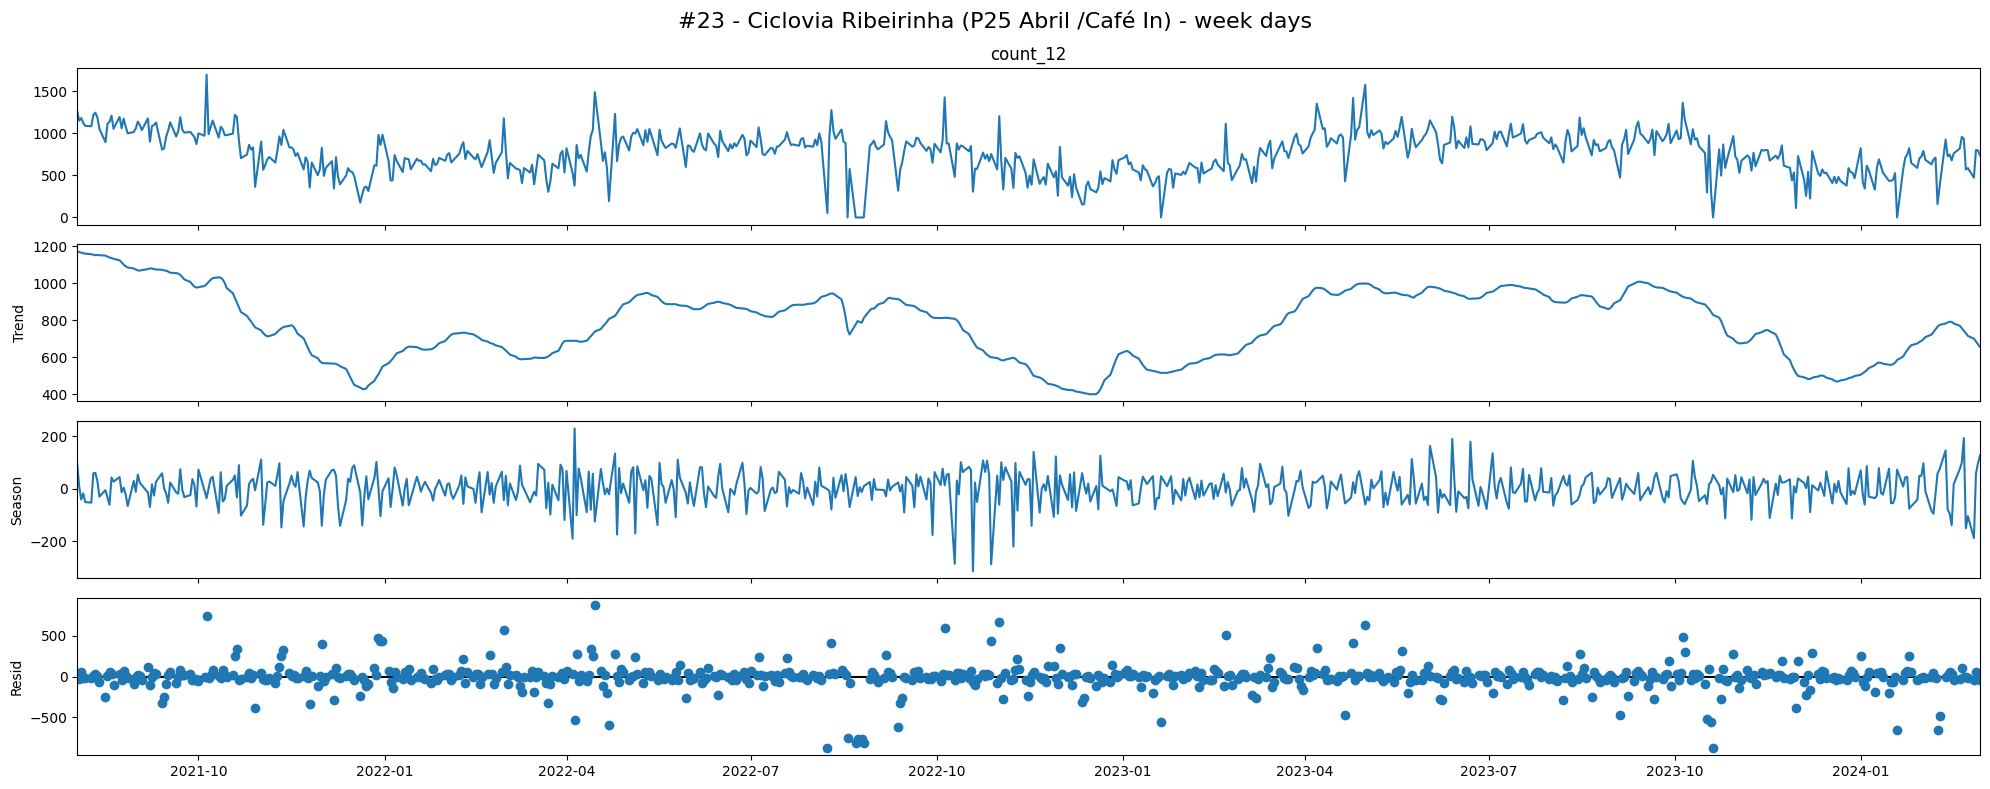

In [ ]:
location_ids = [12] 
# Loop para aplicar STL aos contadores selecionados
for location_id in location_ids:

    if contador in df_daily.columns:
        location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0] 
        series = df_daily[contador]

        weekdays = series[series.index.weekday < 5]  #(segunda a sexta-feira)

        # Função para aplicar STL e gerar gráfico
        def apply_stl_and_plot(data, title):
            stl = STL(data, period=7, robust=True)
            res = stl.fit()

            # Exibe os primeiros valores da decomposição sazonal
            print(f"Results {title}:")
            print(res.seasonal.head())

            # Grafico
            fig = res.plot()
            fig.set_size_inches((20, 8))
            plt.suptitle(title, fontsize=16)
            plt.tight_layout()
            plt.show()

        # Aplica STL para os dias úteis
        print(f"{location_name}")
        apply_stl_and_plot(weekdays, f"{location_name} - week days")



### Por fim de semana 

#23 - Ciclovia Ribeirinha (P25 Abril /Café In)
Results #23 - Ciclovia Ribeirinha (P25 Abril /Café In) - weekend:
detected
2021-08-01    113.800686
2021-08-07    -48.642858
2021-08-08    228.534944
2021-08-14   -207.878491
2021-08-15   -118.642975
Name: season, dtype: float64


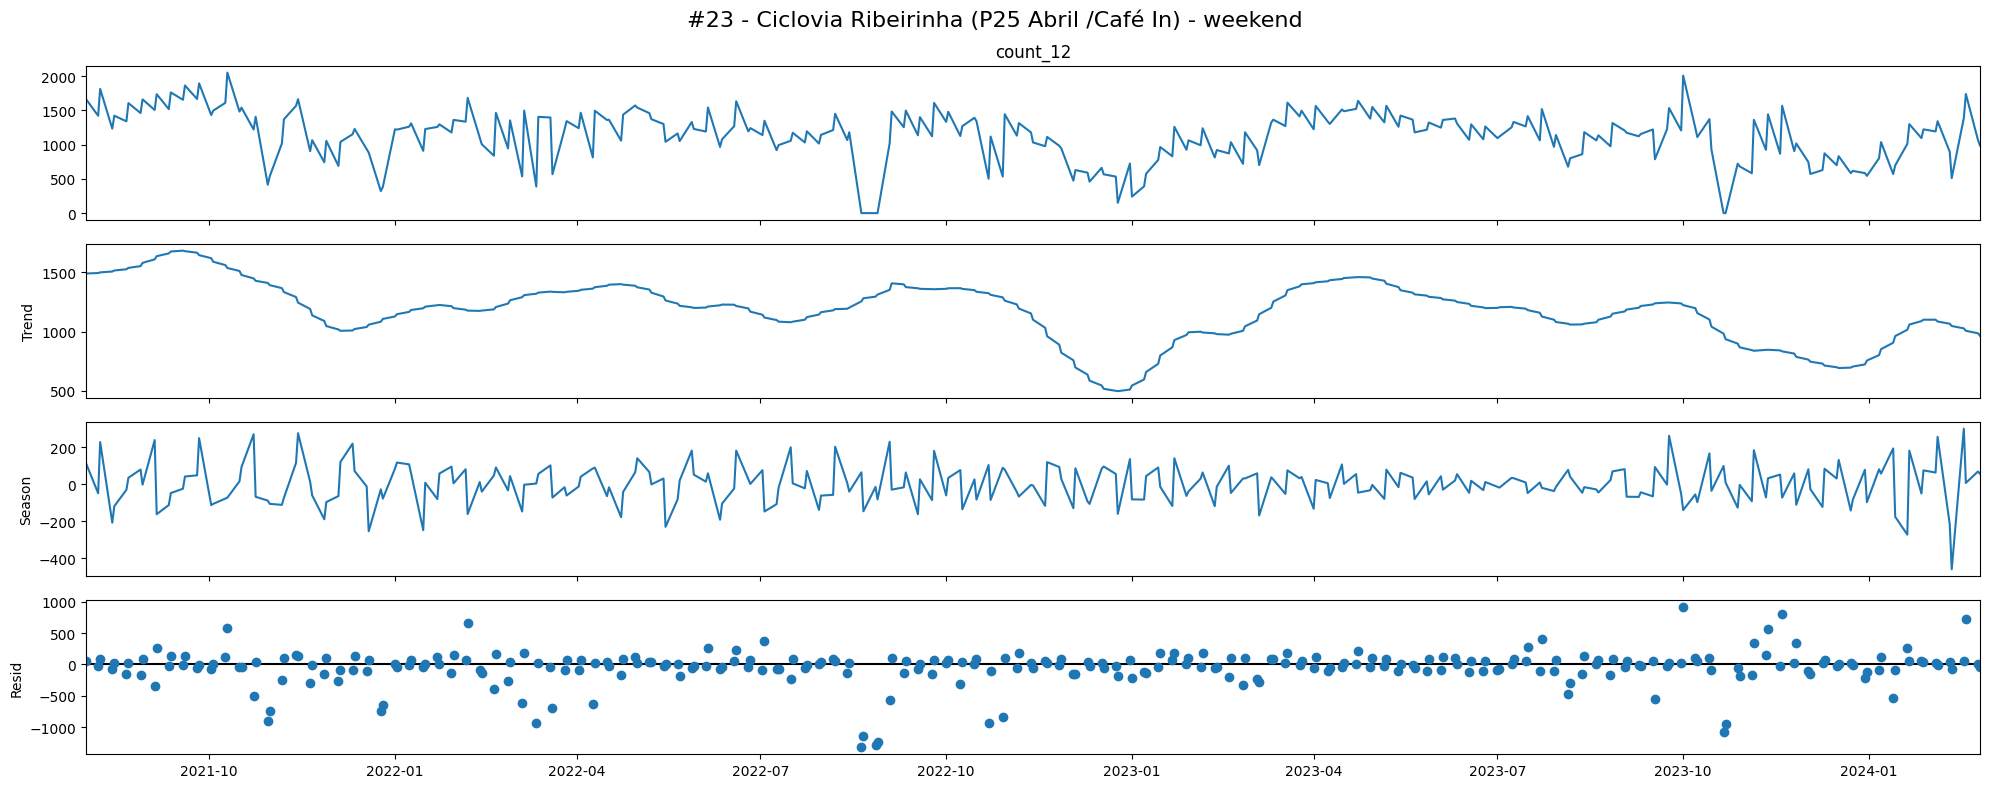

In [18]:
location_ids = [12] 
# Loop para aplicar STL aos contadores selecionados
for location_id in location_ids:

    if contador in df_daily.columns:
        location_name = df_loc[df_loc['locationId'] == location_id]['name'].iloc[0] 
        series = df_daily[contador]

        weekends = series[series.index.weekday >= 5] 

        # Função para aplicar STL e gerar gráfico
        def apply_stl_and_plot(data, title):
            stl = STL(data, period=7, robust=True)
            res = stl.fit()

            # Exibe os primeiros valores da decomposição sazonal
            print(f"Results {title}:")
            print(res.seasonal.head())

            # Grafico
            fig = res.plot()
            fig.set_size_inches((20, 8))
            plt.suptitle(title, fontsize=16)
            plt.tight_layout()
            plt.show()

        # Aplica STL para os fins de semana
        print(f"{location_name}")
        apply_stl_and_plot(weekends, f"{location_name} - weekend")

# Outliers